<a href="https://colab.research.google.com/github/withopenWaigua/TensforflowStudy/blob/main/Basic_regression%EF%BC%88Mutiple_DNN%EF%BC%89_Predict_fuel_efficiency_Noted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [191]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [192]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


下载数据

In [193]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [194]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [195]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [196]:
dataset = dataset.dropna()

	Origin是分类值而不是数字，因此我们使用独热编码np.get_dummies
  先把值映射，再get

In [197]:
np.unique(dataset['Origin'])

array([1, 2, 3])

In [198]:
dataset['Origin'] =dataset['Origin'].map({1:'USA',2:'Europe',3:'Japan'})

In [199]:
dataset = pd.get_dummies(dataset,columns=['Origin'],prefix='', prefix_sep='')

In [200]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


分割训练和测试集

In [201]:
train_dataset = dataset.sample(frac=0.8,random_state=2022)
test_dataset = dataset.drop(train_dataset.index) 

# 探索数据

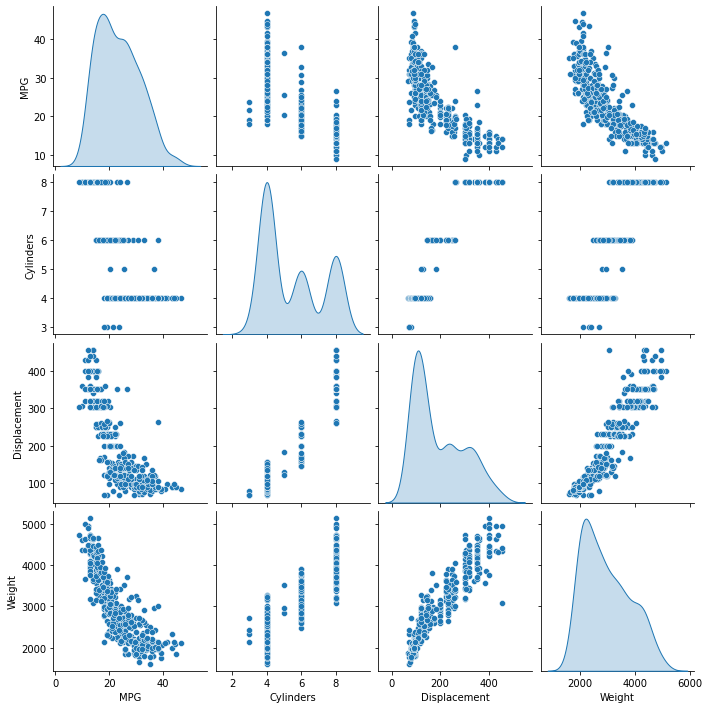

In [202]:
sns.pairplot(dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']],diag_kind='kde')

In [203]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0


# 提取特征

In [204]:
train_feature = train_dataset.copy()
test_feature = test_dataset.copy()

train_labels = train_feature.pop('MPG') #删除某一列返回的值是删除的列
test_labels = test_feature.pop('MPG')

# 正则化

In [205]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.477070,7.773346
Cylinders,5.452229,1.708636
Displacement,194.418790,105.488809
Horsepower,104.726115,39.883634
Weight,2970.012739,853.721640
Acceleration,15.474841,2.757361
Model Year,76.063694,3.688652
Europe,0.175159,0.380710
Japan,0.184713,0.388684
USA,0.640127,0.480729


In [206]:
train_feature

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
148,4,116.0,75.0,2246.0,14.0,74,1,0,0
59,4,97.0,54.0,2254.0,23.5,72,1,0,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0
143,4,97.0,78.0,2300.0,14.5,74,1,0,0
230,8,350.0,170.0,4165.0,11.4,77,0,0,1
...,...,...,...,...,...,...,...,...,...
227,6,225.0,100.0,3630.0,17.7,77,0,0,1
234,4,151.0,88.0,2740.0,16.0,77,0,0,1
240,4,97.0,78.0,2190.0,14.1,77,1,0,0
120,4,121.0,112.0,2868.0,15.5,73,1,0,0


标准化

In [207]:
normalizer = layers.Normalization(axis=-1)#建立标准化层

In [208]:
normalizer.adapt(np.array(train_feature))

In [209]:
print(normalizer.mean.numpy())

[[   5.452  194.419  104.726 2970.013   15.475   76.064    0.175    0.185
     0.64 ]]


In [210]:
first = np.array(train_feature[:1])
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.  116.   75. 2246.   14.   74.    1.    0.    0.]]

Normalized: [[-0.85 -0.74 -0.75 -0.85 -0.54 -0.56  2.17 -0.48 -1.33]]


# 一元线性函数

In [211]:
horsepower = np.array(train_feature['Horsepower'])
horsepower_normalizer = layers.Normalization(input_shape=[1,],axis=None)
horsepower_normalizer.adapt(horsepower)

In [212]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_24 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [213]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [214]:
history = horsepower_model.fit(
    train_feature['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [215]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.884400,3.814100,95
96,3.884952,3.810047,96
97,3.888176,3.807219,97
98,3.883990,3.812459,98
99,3.890569,3.808225,99


In [216]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [217]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_feature['Horsepower'],
    test_labels, verbose=0)

In [218]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [219]:
def plot_horsepower(x, y):
  plt.scatter(train_feature['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

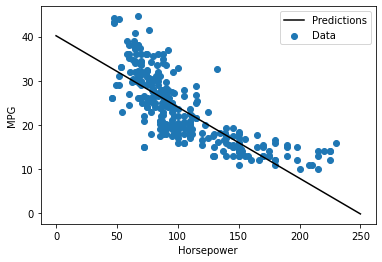

In [220]:
plot_horsepower(x, y)

# Linear regression with multiple inputs

In [221]:
normalizer = layers.Normalization(axis=-1)#建立标准化层
normalizer.adapt(np.array(train_feature)) #喂了数据

In [222]:
linear_model = keras.Sequential([normalizer,layers.Dense(units=1)])

In [223]:
linear_model.predict(train_feature[:10])

array([[-2.325],
       [-4.722],
       [-1.147],
       [-2.229],
       [ 2.815],
       [ 0.84 ],
       [ 0.416],
       [ 2.35 ],
       [-1.068],
       [-0.052]], dtype=float32)

In [224]:
linear_model.layers[1].kernel #查看权重

<tf.Variable 'dense_25/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.638],
       [-0.72 ],
       [ 0.576],
       [ 0.568],
       [-0.624],
       [ 0.139],
       [-0.731],
       [ 0.205],
       [-0.016]], dtype=float32)>

In [225]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [226]:
%%time
history = linear_model.fit(
    train_feature,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2) #验证集自动切割

CPU times: user 5.52 s, sys: 637 ms, total: 6.16 s
Wall time: 5.54 s


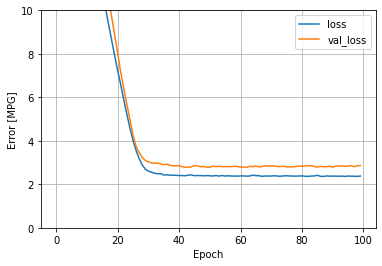

In [227]:
plot_loss(history)

In [228]:
test_results['linear_model'] = linear_model.evaluate(
    test_feature, test_labels, verbose=0)

# Regression with a deep neural network (DNN)

In [229]:
def build_and_compile_model(norm):
  model = keras.Sequential(
      [
       norm,
       layers.Dense(128,activation='relu'),
       layers.Dense(128,activation='relu'),
       layers.Dense(1)
      ]
  )
  model.compile(
        optimizer=keras.optimizers.Adam(lr=0.001),
        loss='mae',
        metrics=['acc']
  )
  return model

In [230]:
horsepower = np.array(train_feature['Horsepower']) #提取np数组
horsepower_normalizer = layers.Normalization(input_shape=[1,],axis=None) #输入的维度是[1,] ，一维axis=None，inputshape=1多维=-1
horsepower_normalizer.adapt(horsepower)
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [231]:
dnn_horsepower_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_26 (Dense)            (None, 128)               256       
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 16,900
Trainable params: 16,897
Non-trainable params: 3
_________________________________________________________________


In [232]:
%%time
history = dnn_horsepower_model.fit(
    train_feature['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.47 s, sys: 699 ms, total: 7.17 s
Wall time: 5.92 s


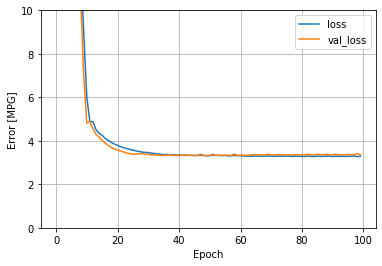

In [233]:
plot_loss(history)

In [234]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

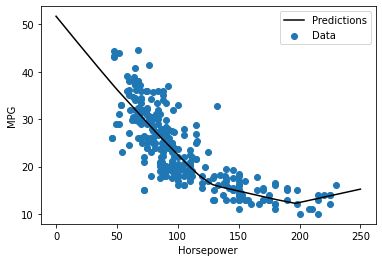

In [235]:
plot_horsepower(x, y)

In [236]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_feature['Horsepower'], test_labels,
    verbose=0)

多特征

In [237]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_14 (Normaliza  (None, 9)                19        
 tion)                                                           
                                                                 
 dense_29 (Dense)            (None, 128)               1280      
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,940
Trainable params: 17,921
Non-trainable params: 19
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [238]:
%%time
history = dnn_model.fit(
    train_feature,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.53 s, sys: 711 ms, total: 7.25 s
Wall time: 6.1 s


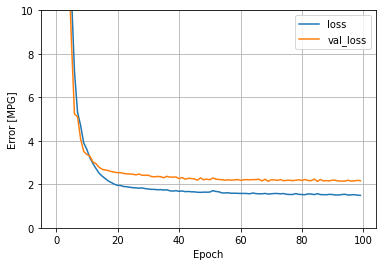

In [239]:
plot_loss(history)

In [240]:
test_results['dnn_model'] = dnn_model.evaluate(test_feature, test_labels, verbose=0)

# 回归模型表现情况

In [241]:
pd.DataFrame(pd.DataFrame(test_results).loc[0,:].T).rename({0:'Mean absolute error [MPG]'},axis=1)

,Mean absolute error [MPG]
horsepower_model,3.585850
linear_model,2.596395
dnn_horsepower_model,3.099414
dnn_model,1.732029


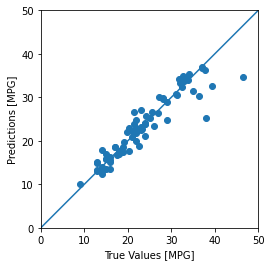

In [242]:
test_predictions = dnn_model.predict(test_feature).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

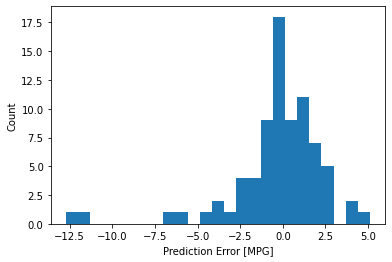

In [243]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [244]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [245]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_feature, test_labels, verbose=0)

In [246]:
pd.DataFrame(pd.DataFrame(test_results).loc[0,:].T).rename({0:'Mean absolute error [MPG]'},axis=1)

,Mean absolute error [MPG]
horsepower_model,3.585850
linear_model,2.596395
dnn_horsepower_model,3.099414
dnn_model,1.732029
reloaded,1.732029
